First 2 conversations:  
 1.  u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']
 
 2.  u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']

First 2 lines:  
 1.  L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
 
 2.  L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!

=====Downloading Existing Data======
 -----TOKENIZED SENTENCE PAIRS-----
tokenized pair -------------------------- 
 (['Can', 'we', 'make', 'this', 'quick', '?', 'Roxanne', 'Korrine', 'and', 'Andrew', 'Barrett', 'are', 'having', 'an', 'incredibly', 'horrendous', 'public', 'break-', 'up', 'on', 'the', 'quad', '.', 'Again', '.', '<EOS>'], ['<SOS>', 'Well', ',', 'I', 'thought', 'we', "'d", 'start', 'with', 'pronunciation', ',', 'if', 'that', "'s", 'okay', 'with', 'you', '.', '<EOS>']) 
-----------------------------------------
tokenized pair -------------------------- 
 (['Well', ',', 'I', 'thought', 'we', "'d", 'start', 'with', 'pronunciation', ',', 'if', 'that', "'s", 'okay', 'wit

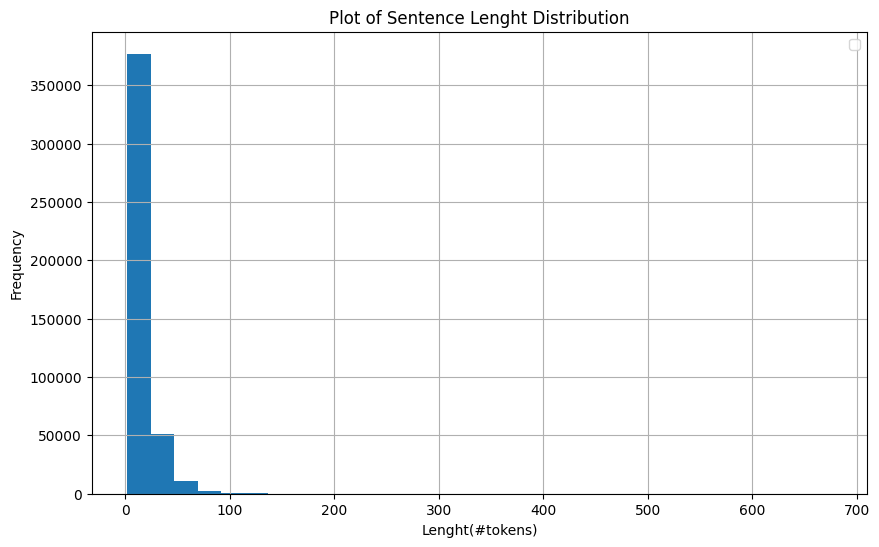

=====Downloading Existing Data======
 -----FILTERED SENTENCE PAIRS-----
len of filtered_pairs:  209803
number of unique sentences: 364004


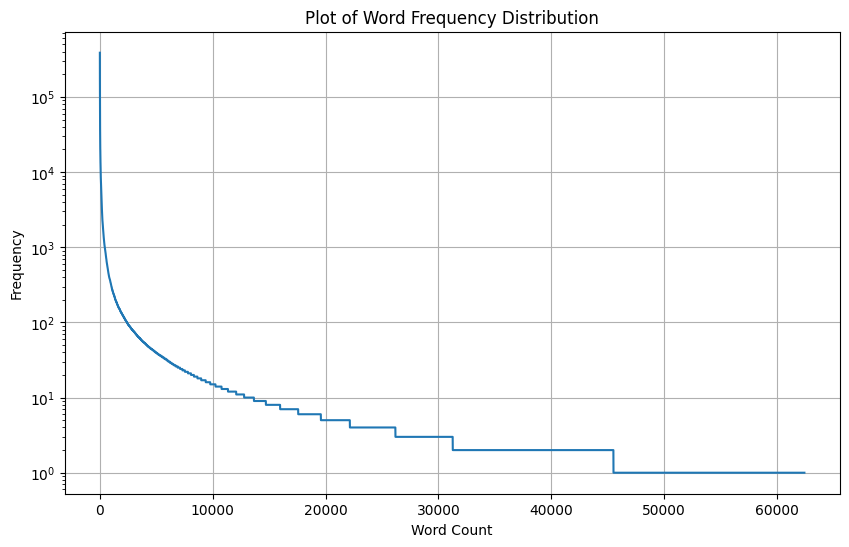

Filtering Sentences: 100%|██████████| 209803/209803 [00:21<00:00, 9621.97it/s] 

2407
number of pairs:  52904
=====Downloading Existing Data======
 -----ALL WORDS-----


In [31]:
'''
Template for the 4th assignment
Student: NAME SURNAME
'''

############################
# Packages
############################
import torch
import torch.nn as nn
import math
import regex as re
import spacy
from tqdm import tqdm
import pickle
import os
import matplotlib.pyplot as plt 
import unicodedata
import collections

############################
#Methods
###########################

# ________________________________FILE_SYSTEM___________________________________

def exists(directory_path, file_name):
    file_path = os.path.join(directory_path, file_name)

    # Check if the file exists
    if os.path.exists(file_path):
        # Check if the file is not empty
        if os.path.getsize(file_path) > 0:
            # Assuming it's a pickle file, you can add additional checks if needed
            if ((file_name.endswith('.pkl')) or (file_name.endswith('.pickle'))):
                return True
            else:
                print(f"The file '{file_name}' is not a pickle file.")
        else:
            print(f"The file '{file_name}' is empty.")
    else:
        print(f"The file '{file_name}' does not exist in the specified directory.")

    return False

# ________________________________TOKENIZATION___________________________________

def tokenize_with_spacy(sentence_pairs, nlp):
    tokenized_pairs = []

    # Apply custom preprocessing rules
    # Include specific punctuation (?, !, ., ,, -) and alphanumeric characters
    allowed_characters = re.escape("?.!,-'")
    
    
    for question, answer in tqdm(sentence_pairs, desc='Tokenizing'):
        # Process the question and answer sentences
        question = re.sub(r'\s+', ' ', re.sub(rf'[^a-zA-Z0-9{allowed_characters}\s]', '', 
                                       re.sub(r'--+', ' ', question)))

        answer = re.sub(r'\s+', ' ', re.sub(rf'[^a-zA-Z0-9{allowed_characters}\s]', '', 
                                     re.sub(r'--+', ' ', answer)))
        
        question_doc = nlp(question)
        answer_doc = nlp(answer)
        
        # Tokenize and append <EOS> and <SOS>
        tokenized_question = [token.text for token in question_doc] + ["<EOS>"]
        tokenized_answer = ["<SOS>"] + [token.text for token in answer_doc] + ["<EOS>"]
        
        # Add the tokenized pair to the list
        tokenized_pairs.append((tokenized_question, tokenized_answer))
    
    return tokenized_pairs


def clear_punctuation(s):
     # Lowercase the text
    s = s.lower()

    # Correctly handle hyphenated words: replace hyphens with a placeholder when part of a word
    s = re.sub(r'(?<=\w)-(?=\w)', 'HYPHENPLACEHOLDER', s)

    # Keep contractions intact: look for apostrophes followed by common contraction endings and prevent space insertion
    contraction_patterns = [r"(?<=\w)'(re|ve|ll|t|s|d|m|n't)"]
    for pattern in contraction_patterns:
        s = re.sub(pattern, r'HYPHENAPOSTROPHE\1', s)

    # Separate punctuation (.,!?) from words
    s = re.sub(r'([,.!?])', r' \1 ', s)

    # Remove all non-word characters except apostrophes, placeholders, spaces, and punctuation
    s = re.sub(r'[^\w\sHYPHENPLACEHOLDERHYPHENAPOSTROPHE,.!?]', '', s)

    # Replace placeholders back with their original characters
    s = s.replace('HYPHENPLACEHOLDER', '-')
    s = s.replace('HYPHENAPOSTROPHE', "'")

    # Replace multiple spaces with a single space
    s = re.sub(r'\s+', ' ', s)

    # Trim leading and trailing spaces
    s = s.strip()

    return s

def tokenize_sentence_pairs(sentence_pairs):
    def tokenize(sentence):
        sentence = clear_punctuation(sentence)
        return sentence.strip().split()

    tokenized_pairs = []
    for question, answer in sentence_pairs:
        tokenized_question = tokenize(question) + ["<EOS>"]
        tokenized_answer = ["<SOS>"] + tokenize(answer) + ["<EOS>"]
        tokenized_pairs.append((tokenized_question, tokenized_answer))

    return tokenized_pairs

# ________________________________DOWNLOADs___________________________________

def read_file(file_path):
        encodings = ['utf-8', 'latin-1', 'windows-1252']
        for encoding in encodings:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    return file.readlines()
            except UnicodeDecodeError:
                continue
        raise ValueError(f"Error: File {file_path} not readable with utf-8, latin-1, or windows-1252 encodings.")

def print2sentences(conversations_path, lines_path):

    conversations = read_file(conversations_path)
    lines = read_file(lines_path)

    print("First 2 conversations:  \n", "1. ", conversations[0], "\n 2. ", conversations[1])
    print("First 2 lines:  \n", "1. ", lines[0], "\n 2. ", lines[1])


# ________________________________TUPLE-IZATION___________________________________

def create_sentence_pairs(conversations_path, lines_path):

    def get_line_id_to_text(lines):
        line_id_to_text = {}
        for line in lines:
            parts = line.strip().split(' +++$+++ ')
#             if len(parts) == 5: #it may happen to have lines 
#                 line_id, _, _, _, text = parts
            line_id = parts[0] #prendi l'ID
            text = parts[-1] # prendi il testo/line
            line_id_to_text[line_id] = text
        return line_id_to_text

    def generate_pairs(conversations, line_id_to_text):
        pairs = []
        for conversation in conversations:
            line_ids_str = conversation.strip().split(' +++$+++ ')[-1]
            line_ids = eval(line_ids_str)
            conv_texts = [line_id_to_text[line_id] for line_id in line_ids if line_id in line_id_to_text]

            for i in range(len(conv_texts) - 1):
                pairs.append((conv_texts[i], conv_texts[i+1]))
        return pairs

    conversations = read_file(conversations_path)
    lines = read_file(lines_path)

    line_id_to_text = get_line_id_to_text(lines)
    pairs = generate_pairs(conversations, line_id_to_text)

    return pairs

# ________________________________PLOTS___________________________________

def plot_distribution(sentence_lenght,toprint=True, label='', title='Plot of Sentence Lenght Distribution', ylabel='Frequency', xlabel='Lenght(#tokens)'):
    if (toprint == True):
        plt.figure(figsize=(10, 6))
        plt.hist(sentence_lengths, bins=30)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        return plt.hist(sentence_lengths, bins=30)

def plot_word_frequency_distribution(word_counts, toprint=True, label='', title='Plot of Word Frequency Distribution', ylabel='Frequency', xlabel='Word Count'):
    frequencies = sorted(word_counts.values(), reverse=True)

    if toprint:
        plt.figure(figsize=(10, 6))
        plt.plot(frequencies, label=label)
        plt.yscale('log')  # Use log scale for better visualization
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        if label:
            plt.legend()
        plt.grid(True)
        plt.show()
    else:
        return plt.plot(frequencies, label=label)


############################
# Classes
############################
# Vocabulary class
class Vocabulary:
    '''
    Class for dealing with our corpus
    '''

    def __init__(self, name, pairs):
        """
        Args:
            name (str): name of the language
            pairs (list): list of pairs of sentences
        """
        self.name = name
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        self.pairs = pairs

    def add_word(self, word):
        '''
        Add a word to the vocabulary
        :param word: a string
        '''
        # TODO: add the word to the vocabulary
        pass

    def add_sentence(self, sentence):
        '''
        Add a sentence to the vocabulary
        :param sentence: list of strings (words)
        '''
        # TODO add the sentence to the vocabulary, this method will call the add_word method
        pass
    

# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, vocabulary, pairs):
        # TODO We want vocabulary and pairs to be attributes of the class
        pass

    def __len__(self):
        # TODO how many pairs do we have?
        pass

    def __getitem__(self, ix):
        # TODO returns two tensors (question, answer) of the pair at index ix
        # TODO the tensors should be of type torch.tensor and should contain integers (word indices)
        pass

class PositionalEncoding(nn.Module):
    '''
    Adapted from
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    '''
    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        try:
            assert x.size(0) < self.max_len
        except:
            print("The length of the sequence is bigger than the max_len of the positional encoding. Increase the max_len or provide a shorter sequence.")
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, pad_id=0, encoder_layers=6, decoder_layers=6, dim_feedforward=2048, num_heads=8, dropout_p=0.1):
        super().__init__()
        # TODO add an embedding layer
        # TODO add a positional encoding layer
        # TODO add a transformer layer, you can use nn.Transformer. You can use the default values for the parameters, but what about batch_first?
        # TODO add a linear layer. Note: output should be probability distribution over the vocabulary


        # Stuff you may need
        self.vocab_size = vocab_size
        self.pad_id = pad_id
        self.num_heads = num_heads

    def create_padding_mask(self, x, pad_id=0):
        # TODO create a boolean mask for the <PAD> tokens
        pass


    def forward(self, src, tgt):
        # S is the source sequence length, T is the target sequence length, N is the batch size, E is the feature number
        # src: (N, S)
        # tgt: (N, T)
        # src_pad_mask: (N, S)
        # tgt_pad_mask: (N, T)
        # mask the future : (N * num_heads, T, T)

        src_pad_mask = self.create_padding_mask(src, self.pad_id) # (N, S)
        tgt_pad_mask = self.create_padding_mask(tgt, self.pad_id) # (N, T)

        src = self.embedding(src)
        tgt = self.embedding(tgt)

        src = self.pos_encoder(src)  # (N, S, E)
        tgt = self.pos_encoder(tgt) # (N, T, E)

        # Mask the memory
        memory_key_padding_mask = src_pad_mask  # (N, S)

        # Mask the future
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1), dtype=torch.bool).to(tgt.device) # (T, T)
        # Expand to make it N * num_heads, T, T
        tgt_mask = tgt_mask.unsqueeze(0).repeat(tgt.size(0) * self.num_heads, 1, 1) # (N, T, T)
        # Transformer
        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask,
                                  tgt_key_padding_mask=tgt_pad_mask, memory_key_padding_mask=memory_key_padding_mask) # (N, T, E)
        # Linear layer
        output = self.linear(output) # (N, T, V)
        return output


###########################
# Main
###########################

if __name__ == "__main__":
    # !!! Don't change the seed !!!
    torch.manual_seed(42)
    # !!!!!!
    
    # Download the data---------------------------------------------------------
    conversations_path = '/kaggle/input/conversations/movie_conversations.txt'
    lines_path = '/kaggle/input/conversations/movie_lines.txt'
    print2sentences(conversations_path, lines_path)
    
    # Create the pairs----------------------------------------------------------
    sentence_pairs = create_sentence_pairs(conversations_path, lines_path)
    #for pair in sentence_pairs[:5]:
        # print(pair)
    
    # Tokenize the data---------------------------------------------------------
    if ((exists("/kaggle/working/", "tokenized_sentence_pairs.pickle") == False)): #or (==False)
    
        
        #tokenized_sentence_pairs = tokenize_sentence_pairs(sentence_pairs)
        nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner", "lemmatizer"])
        print("[en_core_web_sm] model downloaded! \n")
        tokenized_sentence_pairs = tokenize_with_spacy(sentence_pairs, nlp) 
        
        for pair in tokenized_sentence_pairs[:5]:
            print("tokenized pair -------------------------- \n", pair, "\n-----------------------------------------")
        
        print("creating and saving 'tokenized_sentence_pairs.pickle' ... ")
        with open('/kaggle/working/tokenized_sentence_pairs.pickle', 'wb') as handle:
            pickle.dump(tokenized_sentence_pairs, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    else:
        print("=====Downloading Existing Data======\n -----TOKENIZED SENTENCE PAIRS-----")

        with open('/kaggle/working/tokenized_sentence_pairs.pickle', 'rb') as handle:
            tokenized_sentence_pairs = pickle.load(handle)
        
        for pair in tokenized_sentence_pairs[:5]:
            print("tokenized pair -------------------------- \n", pair, "\n-----------------------------------------")
    
    #Filter Sentences-----------------------------------------------------------
    
    #Plot Distribution
    print("number of tuples in tokenized_sentences:", len(tokenized_sentence_pairs) )
    all_sentences = [sentence for pair in tokenized_sentence_pairs for sentence in pair]
    sentence_lengths = [len(sentence) for sentence in all_sentences]
    plot_distribution(sentence_lengths, toprint=True)
    max_length= 50 #look at the graph
    
    # Filter out the sentences that are too long
    if ((exists("/kaggle/working/", "filtered_pairs.pickle") == False)): #or (==False)
        filtered_pairs = []
        for pair in tokenized_sentence_pairs:
            if all(len(sentence) <= max_length for sentence in pair):
                filtered_pairs.append(pair)
        print("creating and saving 'filtered_pairs.pickle' ... ")
        with open('/kaggle/working/filtered_pairs.pickle', 'wb') as handle:
            pickle.dump(filtered_pairs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        print("=====Downloading Existing Data======\n -----FILTERED SENTENCE PAIRS-----")

        with open('/kaggle/working/filtered_pairs.pickle', 'rb') as handle:
            filtered_pairs = pickle.load(handle)
    
    # Filter out the words that are too rare
    
    # Count word frequencies
#     word_counts = collections.Counter()
#     for pair in filtered_pairs:
#         for sentence in pair:
#             for word in sentence:
#                 word_counts.update(word.lower())
    
    word_counts = collections.Counter()
    seen_sentences = set()
    print("len of filtered_pairs: ", len(filtered_pairs))
    sentence_counter= 0
    for pair in filtered_pairs:
        for sentence in pair:
            sentence_str = ' '.join(sentence)  # Convert list of words to a string sentence
            if sentence_str not in seen_sentences:
                seen_sentences.add(sentence_str)
                sentence_counter+=1
                #for word in sentence:
                word_counts.update(sentence)
    #print(word_counts)
    print("number of unique sentences:", sentence_counter)
    plot_word_frequency_distribution(word_counts)
    min_freq = 100
    common_words = []
    
    for word, count in word_counts.items():
        if count >= min_freq:
            common_words.append(word)
    
    filtered_sentences=[]
    
    for pair in tqdm(filtered_pairs, desc='Filtering Sentences'):
        all_words_common = True  # Assume all words are common initially
        for sentence in pair:
            for word in sentence:
                if word not in common_words:
                    all_words_common = False
                    break  
            if not all_words_common:
                break  

    
        if all_words_common:
            filtered_sentences.append(pair)
                    
    
    print(len(common_words))
    print("number of pairs: ", len(filtered_sentences))
    
    
    
    
    
    
    
    
    
    
    if ((exists("/kaggle/working/", "all_words.pickle") == False)):
#         all_words = ['<EOS>','<SOS>']
#         word_recurrence = ['<eos>', '<sos>']
#         for pair in tqdm(filtered_pairs, desc='Creating Word Dictionary'):
#             for sentence in pair:
#                 for word in sentence:# [:-1]
#                     #print("pair: ", pair,"\n sentence: ", sentence, "\n word: ", word)
#                     if word.lower() not in word_recurrence:
#                         word_recurrence.append(word.lower())
#                     if word.lower() not in all_words:
#                         all_words.append(word.lower())
             
#         all_words.append("PAD")
        all_words = set([])  # Use a set for efficient checking and storing
        #word_recurrence = ['<eos>', '<sos>']

        for pair in tqdm(filtered_pairs, desc='Creating Word Dictionary'):
            for sentence in pair:
                for word in sentence:
                    lower_word = word.lower()
                    #if lower_word not in word_recurrence:
                    #if lower_word not in ['<eos>', '<sos>']:
                    if unicodedata.normalize('NFC', word.lower()) != '<eos>' and unicodedata.normalize('NFC', word.lower()) != '<sos>':
                        #word_recurrence.append(lower_word)
                        all_words.add(lower_word)  # Add to set, duplicates will be ignored
        
        all_words = list(all_words)
        all_words = ['<EOS>', '<SOS>'] + all_words + ['PAD']
        #all_words.add("PAD")
            
        #print(len(all_words))
        
        print("creating and saving 'all_words.pickle' ... ")
        with open('/kaggle/working/all_words.pickle', 'wb') as handle:
            pickle.dump(all_words, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        print("=====Downloading Existing Data======\n -----ALL WORDS-----")

        with open('/kaggle/working/all_words.pickle', 'rb') as handle:
            all_words = pickle.load(handle)
    
    #print(all_words[:300])
    
    #print("\n \n \n last element of all_words: ", all_words[-1] )

    # SAVE and put the code above into a function that you will call if you need to generate something slightly different

    # Training loop (Consider writing a function for this/two separate functions for training and validation)

    # Evaluation by feeding the model with one input sentence at a time

    pass